# Module 6 (Vasicek) and Module 7 (CIR)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
def zero_coupon(tau, r0, kappa, theta, sigma, model):
    #tau = tau(:);
    if model == 'Vasicek':
        B = (1 - np.exp(-kappa * tau)) / kappa
        A = (theta - sigma**2 / (2 * kappa**2)) * (B - tau) - (sigma**2 / (4 * kappa)) * B**2
    elif model == 'CIR':
        g = np.sqrt(kappa**2 + 2 * sigma**2)  
        tmp = 2 * kappa * theta / sigma**2
        tmp1 = kappa * tau / 2
        tmp2 = g * tau / 2
        
        A = tmp * np.log(np.exp(tmp1) / (np.cosh(tmp2) + (kappa / g) * np.sinh(tmp2)))
        #B = 2. / (kappa + g * (1. / np.tanh(g * tau / 2)))
        tanh = np.tanh(g * tau / 2)
        B = 2. * tanh / (kappa * tanh + g)
    else:
        print('zero_coupon: model must be "Vasicek" or "CIR"!')
        return -1

    #n1 = len(r0)
    n2 = len(A)
    #A_ = repmat(A,1,n1)
    A_ = A
    #B_ = repmat(B,1,n1)
    B_ = B

    #r_ = repmat(r0,n2,1)
    r_ = np.repeat(r0, n2)

    p = np.exp(A_ - B_ * r_)
    return p

def swapRates(tau, p, mat):
    
    tmax = mat[-1]
    
    ttemp = np.arange(0.5, tmax + 0.5, 0.5)
    ptemp = np.interp(ttemp, tau, p)
    
    dis = np.cumsum(ptemp)
    #dis = dis(:);

    # linear interpolation
    pmat = np.interp(mat, tau, p)

    index = (2 * mat).astype(int) - 1
    S = 100 * 2 * (1 - pmat) / dis[index]
    
    return S

def liborRates(tau, p, mat):
    pmat = np.interp(mat, tau, p)
    L = 100 * (1. / pmat - 1) / mat
    return L

def objFunc1(params, tau, LIBOR, SWAP, model):
    # unpack params
    r0 = params[0]
    kappa = params[1]
    theta = params[2]
    sigma = params[3]

    p = zero_coupon(tau, r0, kappa, theta, sigma, model)
    # now that we have zero-coupon bond prices p(t,T)
    # now it is time to calculate MODEL LIBOR rates and SWAP rates
    S = swapRates(tau, p, SWAP[:,0])
    L = liborRates(tau, p, LIBOR[:,0])

    # the goal is to minimize the distance between model rates and market rates
    rel1 = (S - SWAP[:,1]) / SWAP[:,1]
    rel2 = (L - LIBOR[:,1]) / LIBOR[:,1]

    #rel1 = (S-SWAP(:,2))
    #rel2 = (L-LIBOR(:,2))

    #mae = (sum(abs(rel1))+sum(abs(rel2)))
    mae = np.sum(rel1**2) + np.sum(rel2**2)
    
    return mae

def calibration(fun, param_0, tau, LIBOR, SWAP, model):
     # change tolerance
    opt = {'maxiter':1000, 'maxfev':5e3}
    sol = minimize(objFunc1, params1, args = (tau, LIBOR, SWAP, model), method='Nelder-Mead', options=opt)
    print(sol.message)
    par = np.array(sol.x)
    print('parameters = ' + str(par))
    r_star = par[0]
    kappa_star = par[1]
    theta_star = par[2]
    sigma_star = par[3]
    p = zero_coupon(tau, r_star, kappa_star, theta_star, sigma_star, model)
    L = liborRates(tau, p, LIBOR[:, 0])
    S = swapRates(tau, p, SWAP[:, 0])
    return p, L, S

Data

In [3]:
LIBOR = np.array([[1/12, 1.49078, 2.2795],
    [2/12, 1.52997, 2.33075],
    [3/12, 1.60042, 2.43631],
    [6/12, 1.76769, 2.63525],
    [12/12, 2.04263, 2.95425]])

SWAP = np.array([[2, 2.013, 3.0408],
    [3, 2.1025, 3.1054],
    [5, 2.195, 3.1332],
    [7, 2.2585, 3.1562],
    [10, 2.3457, 3.199],
    [15, 2.4447, 3.2437],
    [30, 2.5055, 3.227]])

Parameters

In [4]:
# we are going out 30 years every month (1/12)
tau = np.arange(0, 30 + 1/12, 1/12)

# initial starting point
# r0 = 0.02 kappa0 = 2 theta0 = 0.5 sigma0 = 0.1
params = np.array([0.02, 1.0, 0.05, 0.3]);

params1 = np.array([0.25, 5, 0.2, 0.1]);
params2 = np.array([0.25, 5, 0.2, 0.1]);

Vasicek (2 dates)

In [5]:
model = 'Vasicek'

In [6]:
# first date
whichOne = 1
p11, L11, S11 = calibration(objFunc1, params1, tau, LIBOR[:,[0,whichOne]], SWAP[:,[0,whichOne]], model) 

Optimization terminated successfully.
parameters = [0.01445667 0.9474955  0.02918339 0.0952191 ]


In [7]:
# second date
whichOne = 2
p12, L12, S12 = calibration(objFunc1, params1, tau, LIBOR[:,[0,whichOne]], SWAP[:,[0,whichOne]], model) 

Optimization terminated successfully.
parameters = [2.13256819e-02 2.82039824e+00 3.21754393e-02 1.27705822e-05]


CIR

In [8]:
model = 'CIR'

In [9]:
# first date
whichOne = 1
p21, L21, S21 = calibration(objFunc1, params1, tau, LIBOR[:,[0,whichOne]], SWAP[:,[0,whichOne]], model) 

Optimization terminated successfully.
parameters = [0.01450723 1.33983861 0.02434852 0.21673566]


In [10]:
# second date
whichOne = 2
p22, L22, S22 = calibration(objFunc1, params1, tau, LIBOR[:,[0,whichOne]], SWAP[:,[0,whichOne]], model) 

Optimization terminated successfully.
parameters = [0.02132201 2.78197716 0.03235121 0.29123648]


Plots

Vasicek

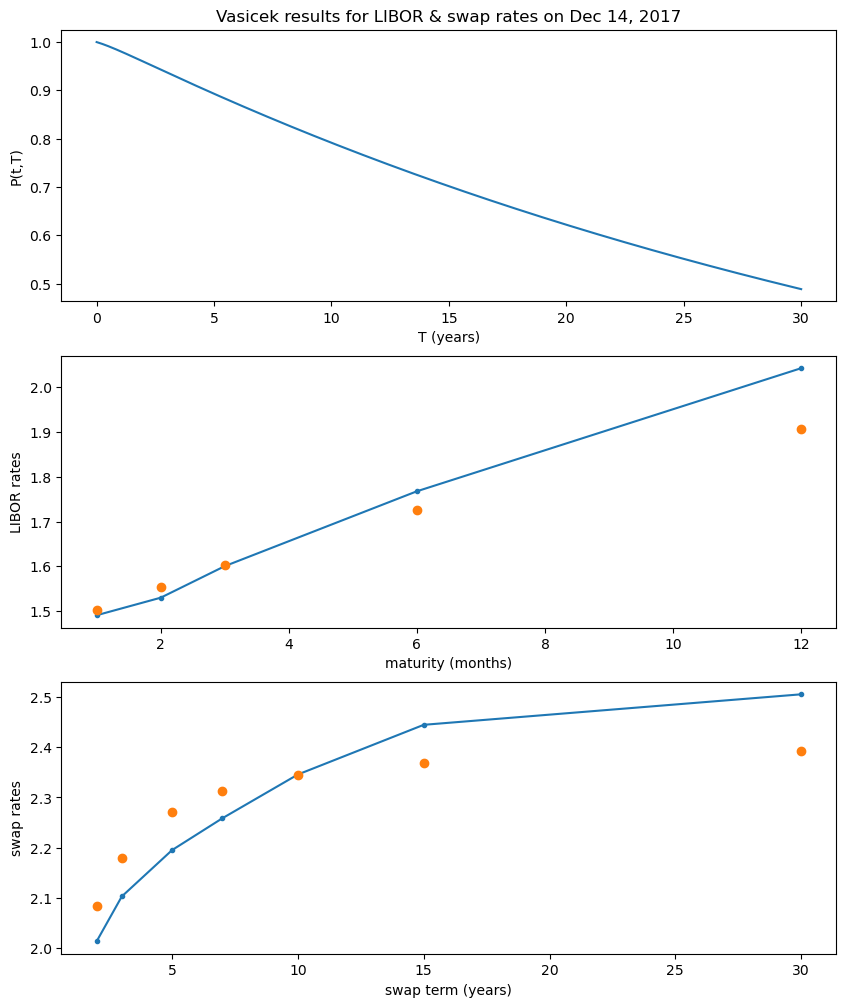

In [11]:
# vasicek first date
whichOne = 1
dataDate = 'Dec 14, 2017';
    
plt.figure(figsize=(10,12))

plt.subplot(3,1,1)
plt.plot(tau, p11)
plt.xlabel('T (years)')
plt.ylabel('P(t,T)')
plt.title('Vasicek results for LIBOR & swap rates on ' + dataDate)

plt.subplot(3,1,2)
plt.plot(12 * LIBOR[:,0], LIBOR[:,whichOne], '.-')
plt.plot(12 * LIBOR[:,0], L11, 'o')
plt.xlabel('maturity (months)')
plt.ylabel('LIBOR rates')

plt.subplot(3,1,3)
plt.plot(SWAP[:,0], SWAP[:,whichOne], '.-')
plt.plot(SWAP[:,0], S11, 'o')
plt.xlabel('swap term (years)')
plt.ylabel('swap rates')

plt.show()

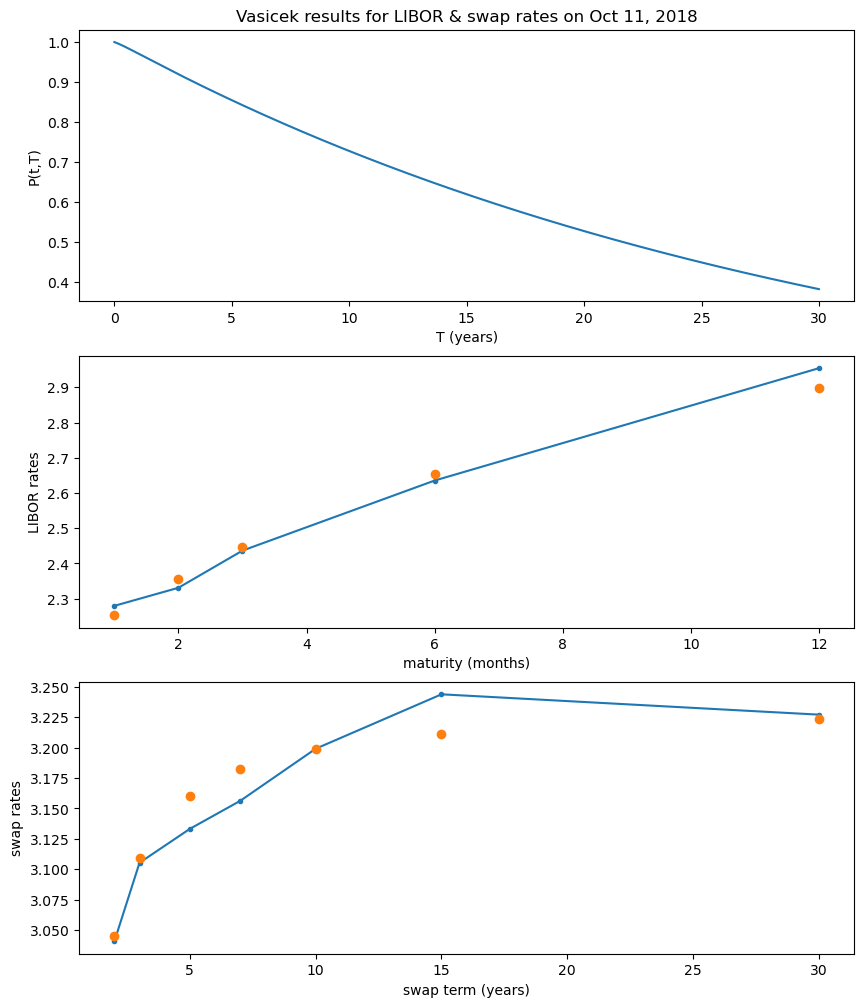

In [12]:
# vasicek second date
whichOne = 2
dataDate = 'Oct 11, 2018';
    
plt.figure(figsize=(10,12))

plt.subplot(3,1,1)
plt.plot(tau, p12)
plt.xlabel('T (years)')
plt.ylabel('P(t,T)')
plt.title('Vasicek results for LIBOR & swap rates on ' + dataDate)

plt.subplot(3,1,2)
plt.plot(12 * LIBOR[:,0], LIBOR[:,whichOne], '.-')
plt.plot(12 * LIBOR[:,0], L12, 'o')
plt.xlabel('maturity (months)')
plt.ylabel('LIBOR rates')

plt.subplot(3,1,3)
plt.plot(SWAP[:,0], SWAP[:,whichOne], '.-')
plt.plot(SWAP[:,0], S12, 'o')
plt.xlabel('swap term (years)')
plt.ylabel('swap rates')

plt.show()

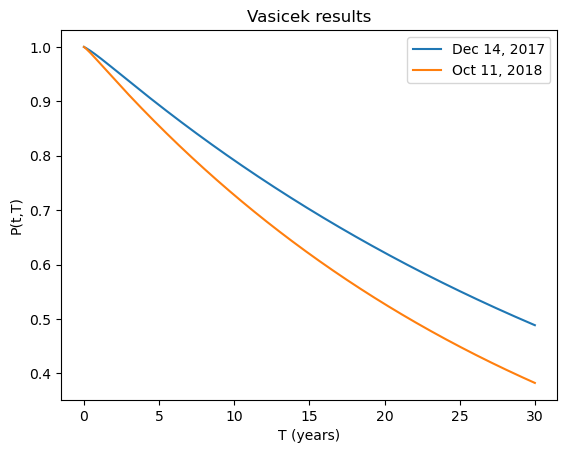

In [13]:
# vasicek comparison
plt.figure()
plt.plot(tau, p11)
plt.plot(tau, p12)
plt.xlabel('T (years)')
plt.ylabel('P(t,T)')
plt.legend(['Dec 14, 2017', 'Oct 11, 2018'])
plt.title('Vasicek results')
plt.show()

CIR

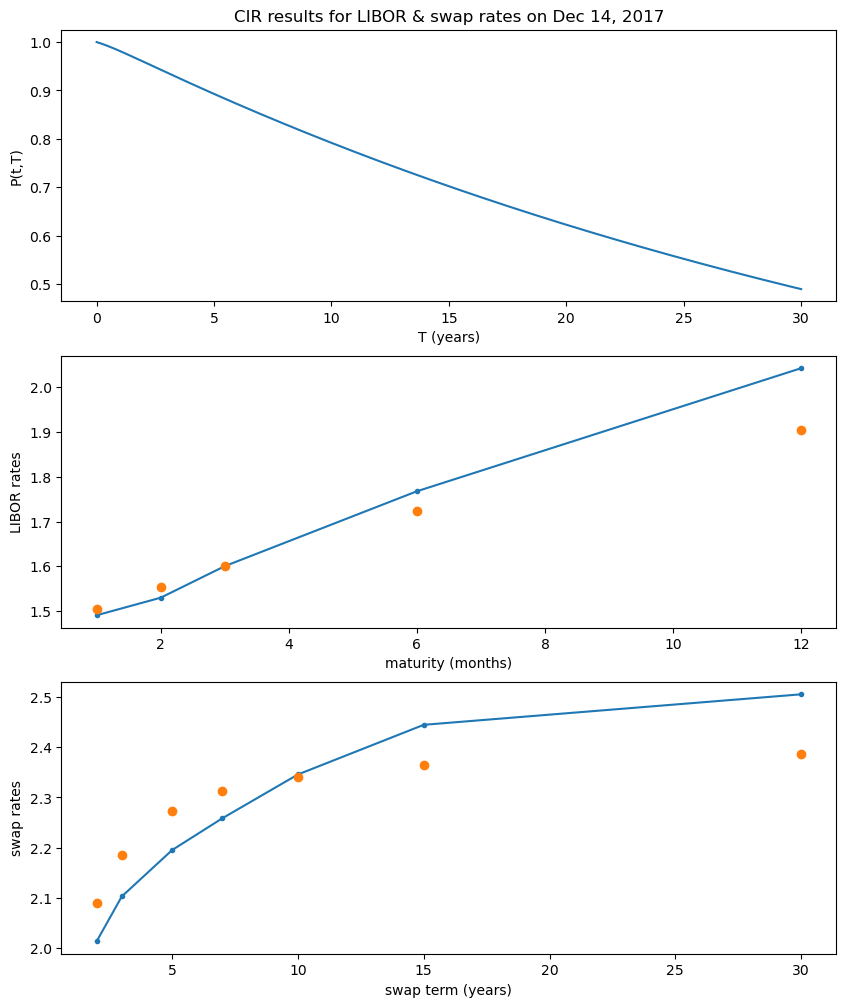

In [14]:
# cir first date
whichOne = 1
dataDate = 'Dec 14, 2017';
    
plt.figure(figsize=(10,12))

plt.subplot(3,1,1)
plt.plot(tau, p21)
plt.xlabel('T (years)')
plt.ylabel('P(t,T)')
plt.title('CIR results for LIBOR & swap rates on ' + dataDate)

plt.subplot(3,1,2)
plt.plot(12 * LIBOR[:,0], LIBOR[:,whichOne], '.-')
plt.plot(12 * LIBOR[:,0], L21, 'o')
plt.xlabel('maturity (months)')
plt.ylabel('LIBOR rates')

plt.subplot(3,1,3)
plt.plot(SWAP[:,0], SWAP[:,whichOne], '.-')
plt.plot(SWAP[:,0], S21, 'o')
plt.xlabel('swap term (years)')
plt.ylabel('swap rates')

plt.show()

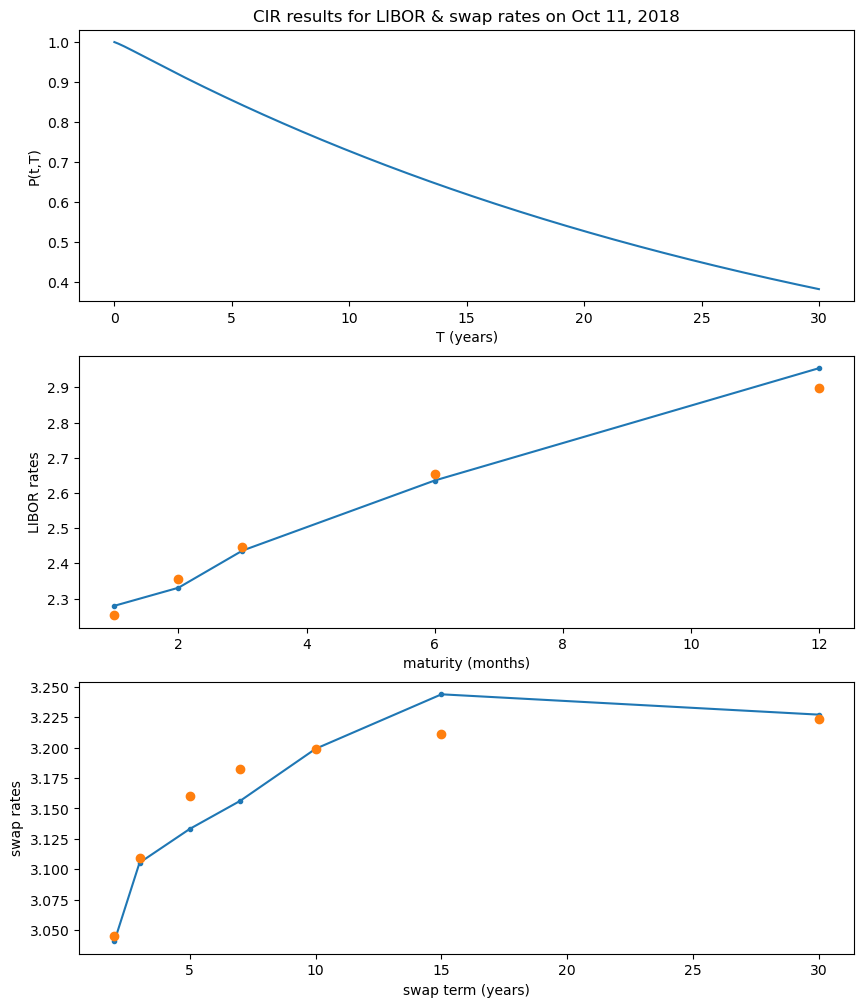

In [15]:
# cir second date
whichOne = 2
dataDate = 'Oct 11, 2018';
    
plt.figure(figsize=(10,12))

plt.subplot(3,1,1)
plt.plot(tau, p22)
plt.xlabel('T (years)')
plt.ylabel('P(t,T)')
plt.title('CIR results for LIBOR & swap rates on ' + dataDate)

plt.subplot(3,1,2)
plt.plot(12 * LIBOR[:,0], LIBOR[:,whichOne], '.-')
plt.plot(12 * LIBOR[:,0], L22, 'o')
plt.xlabel('maturity (months)')
plt.ylabel('LIBOR rates')

plt.subplot(3,1,3)
plt.plot(SWAP[:,0], SWAP[:,whichOne], '.-')
plt.plot(SWAP[:,0], S22, 'o')
plt.xlabel('swap term (years)')
plt.ylabel('swap rates')

plt.show()

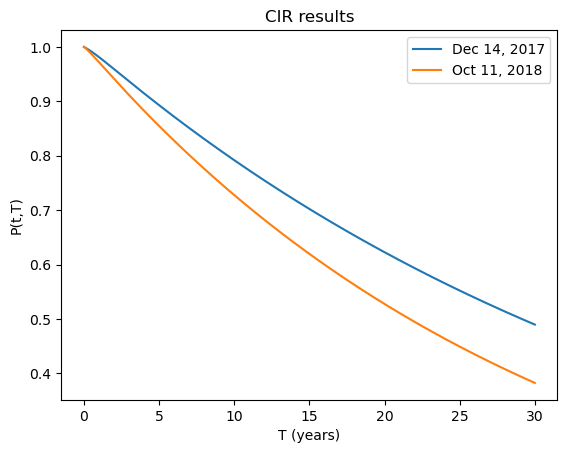

In [16]:
# cir comparison
plt.figure()
plt.plot(tau, p21)
plt.plot(tau, p22)
plt.xlabel('T (years)')
plt.ylabel('P(t,T)')
plt.legend(['Dec 14, 2017', 'Oct 11, 2018'])
plt.title('CIR results')
plt.show()